<a href="https://colab.research.google.com/github/zeynepaycan/stock-price-prediction-prophet/blob/main/stockpriceprediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

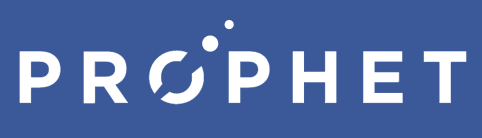

# Prophet Algoritması ile Hisse Fiyatı Tahminleme



**Prophet nedir?** \
Resmî Prophet algoritması sayfasında prophetin tanımı olarak aşağıdaki gibi yazmaktadır;

Prophet, doğrusal olmayan eğilimlerin yıllık, haftalık ve günlük mevsimsellik artı tatil etkileri ile uyumlu olduğu ek bir modele dayalı zaman serisi verilerini tahmin etmek için bir prosedürdür. En iyi, güçlü mevsimsel etkilere ve birkaç sezonluk geçmiş verilere sahip zaman serileriyle çalışır. Prophet, eksik verilere ve trenddeki değişikliklere karşı dayanıklıdır ve tipik olarak aykırı değerleri iyi idare eder.





Prophet, Facebook’un Core Data Science ekibi tarafından yayınlanan açık kaynaklı bir yazılımdır. CRAN ve PyPI üzerinden indirilebilir.

Bu nedenle, Prophet, Facebook'un zaman serisi tahminleri yapmak için kullandığı açık kaynak aracıdır.

Prophet, zaman serisi verilerini **trend, mevsimsellik ve tatil etkisi**'ne ayırır.

**Trend**, zaman serisi verilerindeki periyodik olmayan değişiklikleri modeller.

**Mevsimsellik**; günlük, haftalık veya yıllık mevsimsellik gibi dönemsel değişikliklerden kaynaklanır.

**Tatil etkisi**, bir gün veya bir kaç gün boyunca düzensiz programlarda ortaya çıkan etkidir.

**Hata terimleri**, model tarafından açıklanmayan etkidir.

**Artıları**:
- Kullanımı oldukça kolay.
- Hızlıdır. Planlama ve hedef belirleme için güvenilir tahminler üretmek için Facebook'taki birçok uygulamada kullanılır.
- Birden fazla mevsimlik belirtmeye izin verir.
- Özel olayların belirlenmesine izin verir.
- Prophet ayarlanabilir tahminler üretir. Kullanıcıların tahminleri değiştirmesi ve ayarlaması için birçok olasılık içerir.
- Aykırı ve eksik verilere karşı sağlamdır.

**Eksileri**:
- Yalnızca tek değişkenli zaman serilerini işleyebilir


**Matematiksel olarak en basit haliyle gösterimi**

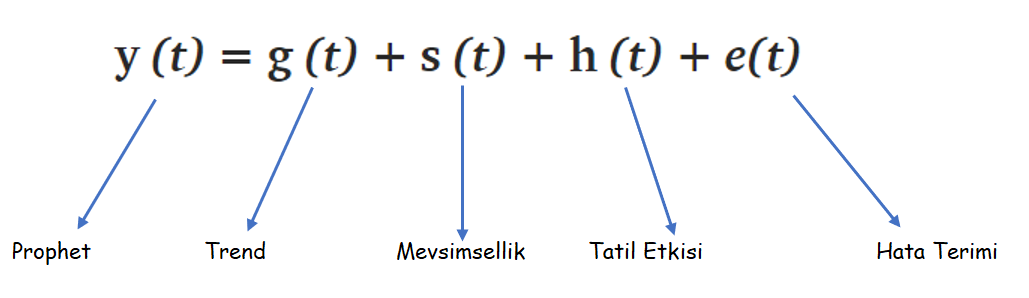

In [ ]:
#### Libraries ## Kütüphaneler #####
%matplotlib inline
import itertools
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error #r^2 hesaplaması için
import math                  #Matematiksel işlemler için
import matplotlib            #Veri görselleştirilmesi için
import multiprocessing
import numpy as np
import pandas as pd          #Veri işlemek, anlamlandırmak için
import seaborn as sns        #İstatiksel grafikler için
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from datetime import date, datetime, timedelta
from fbprophet import Prophet #Prophet Algoritması için
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.metrics import mean_squared_error    
from tqdm import tqdm_notebook        ## ProgressBars

## Giriş Parametreleri ####
stk_path = "/content/APPLE.csv"           ## APPLE Historical financial stock market values
holidays_path = "/content/holidays.csv"   # Amerika Borsa Tatil günlerinin csv dosyası // csv file containing holidays in the US
H = 21                                    # Tahminleme Uzunluğu // Forecast Horizon
train_size=503                            # 2 yıl eğitim için seçilmiştir. Yaklaşık olarak bir yılda 252 işlem günü vardır. Use 2 years of data as train set. Note there are about 252 trading days in a year

#############################################

print("Eğitim setinin Büyüklüğü = " + str(train_size))

Eğitim setinin Büyüklüğü = 503


In [ ]:
#### Loss Functions ## Kayıp Fonksiyonları ######

def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def get_mae(a, b):
    """
    Comp mean absolute error e_t = E[|a_t - b_t|]. a and b can be lists.
    Returns a vector of len = len(a) = len(b)
    """
    return np.mean(abs(np.array(a)-np.array(b)))

def get_rmse(a, b):
    """
    Comp RMSE. a and b can be lists.
    Returns a scalar.
    """
    return math.sqrt(np.mean((np.array(a)-np.array(b))**2))

def get_r2 (a, b):
    """
    Comp R^2. a and b can be lists.
    Returns a scalar.
    """
    return r2_score(a, b)

In [ ]:
#Apple Hisse Senedi Verilerinin Okunması
df = pd.read_csv(stk_path, sep = ",")

# Tarih kolonunun formatının datetime'a dönüştürülmesi
df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')

# Tarihe göre sıralanması
df.sort_values(by='Date', inplace=True, ascending=True)

# Verilerin Büyüklüğü
print("Veri sayısı: " + str(len(df)))

df.head(10)

Veri sayısı: 756


,Date,Open,High,Low,Adj Close,Volume
0,2018-01-02,42.540001,43.075001,42.314999,41.380238,102223600
1,2018-01-03,43.132500,43.637501,42.990002,41.373032,118071600
2,2018-01-04,43.134998,43.367500,43.020000,41.565216,89738400
3,2018-01-05,43.360001,43.842499,43.262501,42.038452,94640000
4,2018-01-08,43.587502,43.902500,43.482498,41.882305,82271200
5,2018-01-09,43.637501,43.764999,43.352501,41.877506,86336000
6,2018-01-10,43.290001,43.575001,43.250000,41.867889,95839600
7,2018-01-11,43.647499,43.872501,43.622501,42.105709,74670800
8,2018-01-12,44.044998,44.340000,43.912498,42.540501,101672400
9,2018-01-16,44.474998,44.847500,44.035000,42.324310,118263600


In [ ]:
#Veriler hakkında özet bilgilerin elde edilmesi
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 756 entries, 0 to 755
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       756 non-null    datetime64[ns]
 1   Open       756 non-null    float64       
 2   High       756 non-null    float64       
 3   Low        756 non-null    float64       
 4   Adj Close  756 non-null    float64       
 5   Volume     756 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 41.3 KB


In [ ]:
#Sayısal verilere sahip olan sütunların max, min , std…gibi istatiksel değerlerinin görüntülenmesi.
df.describe()

,Open,High,Low,Adj Close,Volume
count,756.000000,756.000000,756.000000,756.000000,7.560000e+02
mean,64.901078,65.687440,64.154517,64.039674,1.352843e+08
std,25.750101,26.140361,25.265343,26.054833,6.107174e+07
min,35.994999,36.430000,35.500000,34.669640,4.544800e+07
25%,46.526875,46.900624,46.174999,45.182574,9.311270e+07
50%,54.127501,54.834999,53.375000,52.563511,1.208860e+08
75%,77.147501,78.218752,76.302502,76.673529,1.613882e+08
max,138.050003,138.789993,134.339996,136.486053,4.265100e+08


In [ ]:
#Veri Setinde Boş Veri Kontrolü
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Adj Close    0
Volume       0
dtype: int64

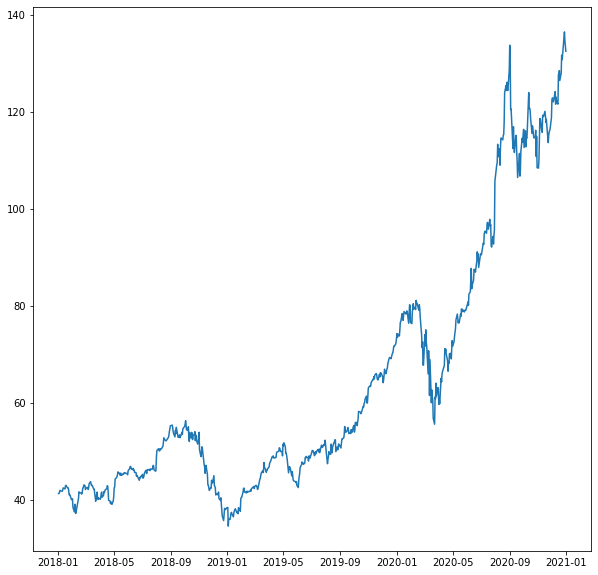

In [ ]:
#APPL Hisse Senedinin 2018-2021 Yılları arasındaki Grafiği
plt.figure(figsize=(10,10))
plt.plot(df['Date'],df['Adj Close'])

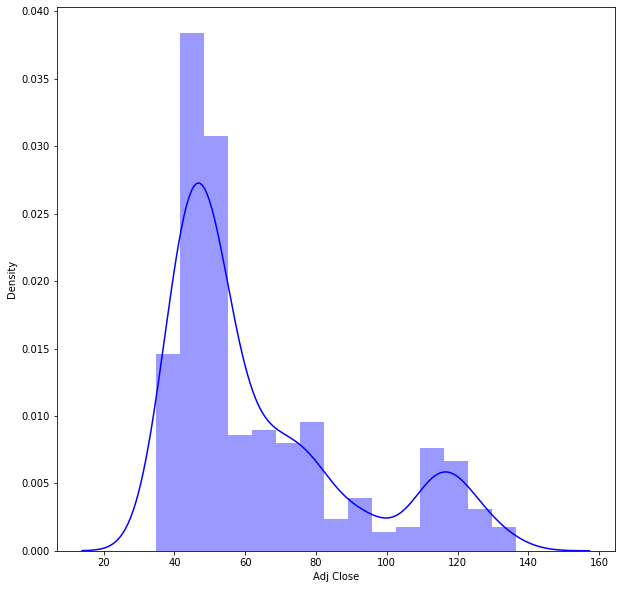

In [ ]:
#Ayarlanmış Kapanış Fiyatı (Adj Close) dağılım grafiği
plt.figure(figsize=(10,10))
sns.distplot(df['Adj Close'], color='b')

In [ ]:
#APPL Hisse Senedinin 2018-2021 yılları aradındaki Mum Grafiği
import plotly.graph_objects as go

import pandas as pd
from datetime import datetime

fig = go.Figure(data=[go.Candlestick(x=df['Date'],
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Adj Close'])])

fig.show()


In [ ]:
#Veri Setinin Tarih Aralığı
df['Date'].min(), df['Date'].max() 

(Timestamp('2018-01-02 00:00:00'), Timestamp('2020-12-31 00:00:00'))

In [ ]:
# Verilerin Prophet algoritması için hazırlanması
df_prophet = df[['Date', 'Adj Close']].rename(columns={'Date':'ds', 'Adj Close':'y'})
df_prophet.head()


,ds,y
0,2018-01-02,41.380238
1,2018-01-03,41.373032
2,2018-01-04,41.565216
3,2018-01-05,42.038452
4,2018-01-08,41.882305


In [ ]:
i = train_size # Eğitim verisinin tanımlanması
print(" Tarih : %s'inden itibaren (%d. gün), %d günlük tahmin" % (df_prophet.iloc[i]['ds'].strftime("%m/%d/%Y"),i, H))

 Tarih : 01/02/2020'inden itibaren (503. gün), 21 günlük tahmin


In [ ]:

m = Prophet()
m.fit(df_prophet) 
df_cv = cross_validation(m, initial='503 days',horizon='15 days', period='5 days', parallel="processes")
df_p = performance_metrics(df_cv, rolling_window=1)
df_r = get_r2(df_cv['y'],df_cv['yhat'])
rmses_parametresiz=df_p['rmse'].values[0]
mses_parametresiz=df_p['mse'].values[0]
maes_parametresiz=df_p['mae'].values[0]
mapes_parametresiz=df_p['mape'].values[0]
r2_parametresiz=df_r
print(df_cv)
# Hata metriklerinin hesaplanması

print('Rmses:{0} ' .format(rmses_parametresiz))
print('MSES:{0}  '.format(mses_parametresiz))
print('Maes:{0} ' .format(maes_parametresiz))
print('R2:{0} '  .format(r2_parametresiz))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 43 forecasts with cutoffs between 2019-05-20 00:00:00 and 2019-12-16 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fdf21618510>


            ds       yhat  yhat_lower  yhat_upper          y     cutoff
0   2019-05-21  51.428372   49.492888   53.313218  45.869057 2019-05-20
1   2019-05-22  51.666950   49.662356   53.653154  44.930046 2019-05-20
2   2019-05-23  51.756686   49.850977   53.861271  44.163101 2019-05-20
3   2019-05-24  51.695786   49.702981   53.766606  43.993488 2019-05-20
4   2019-05-28  52.158445   50.185276   54.113946  43.811584 2019-05-20
..         ...        ...         ...         ...        ...        ...
443 2019-12-24  68.117565   66.028554   70.209547  70.353882 2019-12-16
444 2019-12-26  68.514014   66.379206   70.566157  71.749733 2019-12-16
445 2019-12-27  68.562061   66.266609   70.657398  71.722488 2019-12-16
446 2019-12-30  68.871445   66.685355   70.909050  72.148178 2019-12-16
447 2019-12-31  69.026434   66.743024   70.910989  72.675339 2019-12-16

[448 rows x 6 columns]
0.8188559582006076
Rmses:3.1339511399687097 
MSES:9.821649747711175  
Maes:2.4714540919576797 
R2:0.818855958200

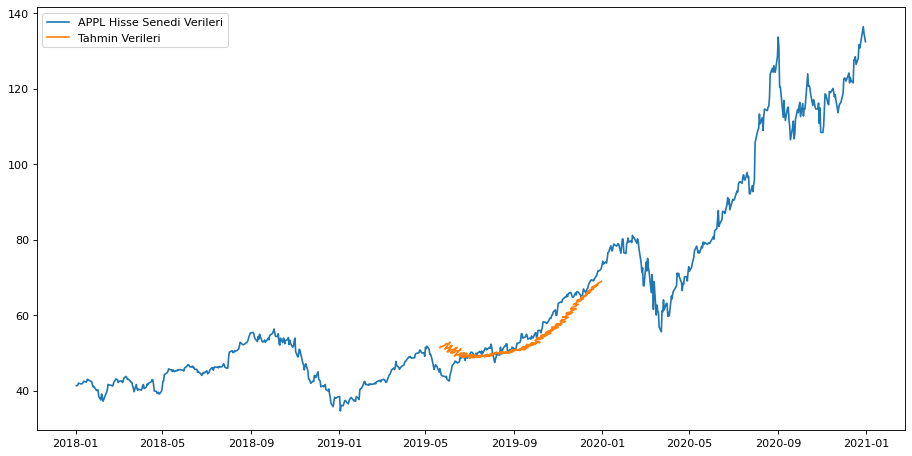

In [ ]:
plt.figure(figsize=[14,7],dpi=80)
plt.plot(df['Date'],df['Adj Close'])
plt.plot(df_cv['ds'],df_cv['yhat'])
plt.legend(['APPL Hisse Senedi Verileri','Tahmin Verileri'])
plt.savefig(fname="Tahminleme.png")

In [ ]:
# Prophet Modeli Fitleme
m = Prophet()
m.fit(df_prophet[i-train_size:i])

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
#Tahmin etmek istediğimiz tarihlerle future dataframe (gelecek veri çerçevesi) oluşturulması
future = m.make_future_dataframe(periods=H)

In [ ]:
# Gelecekteki verilerden hafta sonunu çıkarılması
future['day'] = future['ds'].dt.weekday
future = future[future['day']<=4]
print(future.head(10))
future.to_csv('Future.csv')
# Tahminleme Methodu ile tahminlemenin yapılması(Alt sınır ve üst sınır tahminlerinin yapılması) 
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
forecast.to_csv('Forecast.csv')

          ds  day
0 2018-01-02    1
1 2018-01-03    2
2 2018-01-04    3
3 2018-01-05    4
4 2018-01-08    0
5 2018-01-09    1
6 2018-01-10    2
7 2018-01-11    3
8 2018-01-12    4
9 2018-01-16    1


Gelecek verilerin dataframe'ini oluştururken hafta sonunu da işin içine katıldığı görülmüştür. Bizim verilerimizde hafta sonu dahil olmadığı için hata oranları çok daha büyük ve yanlış çıkmıştır. Bu nedenle gelecek verilerinden hafta sonları çıkarılmıştır.

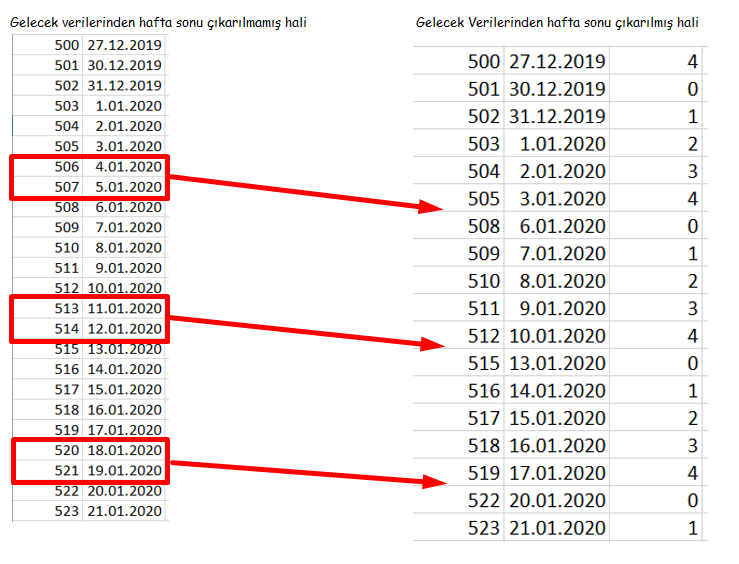

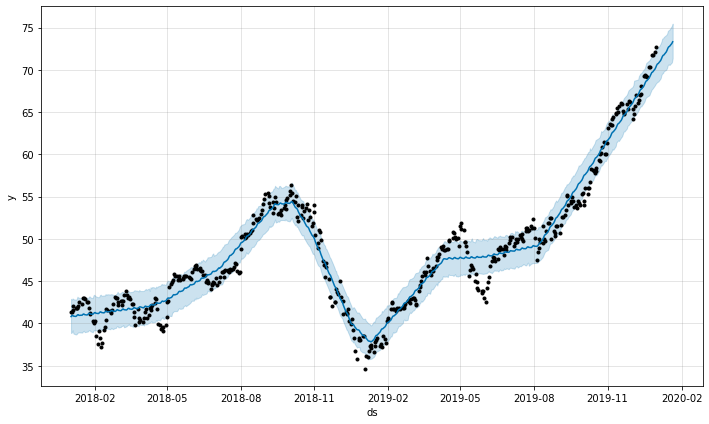

In [ ]:
# Plot
m.plot(forecast);

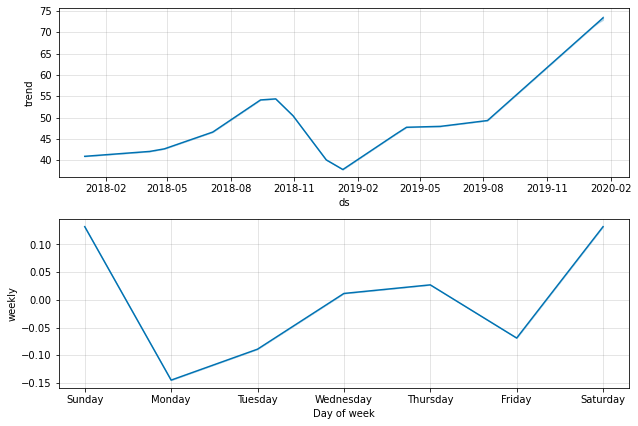

In [ ]:
# Bileşenleri Çizme
m.plot_components(forecast);

In [ ]:
# Hata metriklerinin hesaplanması
preds_list = forecast['yhat'][train_size:len(future)]
print("%s tarihinden itibaren (%d. gün) , %d günlük tahminin RMSE değeri %f" % ( df['Date'][i].strftime("%m/%d/%Y"),i,len(future)-i, get_rmse(df_prophet[train_size:len(future)]['y'], preds_list)))
print("%s tarihinden itibaren (%d. gün) , %d günlük tahminin ortalama MAPE değeri %f" % (df['Date'][i].strftime("%m/%d/%Y"),i,len(future)-i, get_mape(df_prophet[train_size:len(future)]['y'], preds_list)))
print("%s tarihinden itibaren (%d. gün) , %d günlük tahminin ortalama MAE değeri %f" % (df['Date'][i].strftime("%m/%d/%Y"),i,len(future)-i, get_mae(df_prophet[train_size:len(future)]['y'], preds_list)))
print("%s tarihinden itibaren (%d. gün) , %d günlük tahminin ortalama R2 değeri %f" % (df['Date'][i].strftime("%m/%d/%Y"),i,len(future)-i, get_r2( df_prophet[train_size:len(future)]['y'], preds_list )))

01/02/2020 tarihinden itibaren (503. gün) , 15 günlük tahminin RMSE değeri 4.933064
01/02/2020 tarihinden itibaren (503. gün) , 15 günlük tahminin ortalama MAPE değeri 6.223395
01/02/2020 tarihinden itibaren (503. gün) , 15 günlük tahminin ortalama MAE değeri 4.796813
01/02/2020 tarihinden itibaren (503. gün) , 15 günlük tahminin ortalama R2 değeri -5.734476


(737423.0, 737452.0)

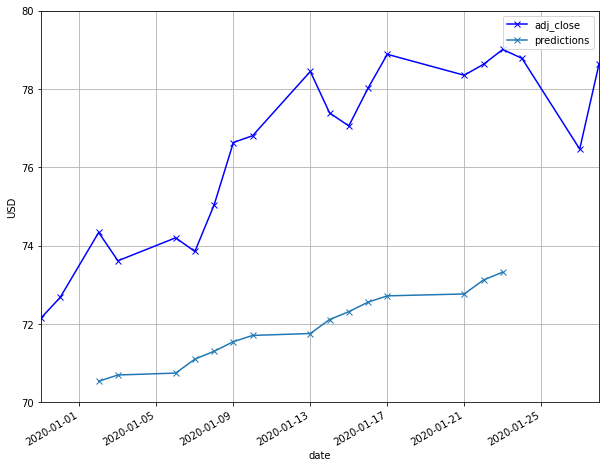

In [ ]:
# Tahminlerin çizilmesi
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='Date', y='Adj Close', style='bx-', grid=True)

ax.plot(df['Date'][i:len(future)], preds_list, marker='x')
    
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.legend(['adj_close', 'predictions'])
ax.set_ylim([70, 80])
ax.set_xlim([date(2019, 12, 30), date(2020, 1, 28)])

# Prophet Algoritmasında Belirlenmesi Gereken Parametreler


1.   **growth='linear',** Büyümenin Doğrusal veya lojistik eğilimi belirtmek için 'doğrusal' veya 'lojistik' olarak belirlenebilir. Eğer "Logistic olarak belirlenmez ise default olarak "Doğrusal" kullanılır. Doğrusal, doygunluk büyümesi olmayanlar için en uygun olanıdır.

2.   **changepoints=None,** Potansiyel değişim noktalarını içerecek tarihlerin listesi. Belirtilmezse, potansiyel değişim noktaları otomatik olarak seçilir.
3.   **n_changepoints=25,** Dahil edilecek potansiyel değişim noktası sayısı. Giriş değişiklik noktaları sağlandıysa kullanılmaz. Değişim noktaları sağlanmadıysa, n_changepoints potansiyel değişim noktası geçmişin ilk değişiklik noktası_aralığı oranından eşit olarak seçilir.
4.   **changepoint_range=0.8,**  Trend değişim noktalarının tahmin edileceği geçmişin oranı. İlk% 80 için varsayılan değer 0,8'dir. Değişiklik noktaları belirtilmişse kullanılmaz.
5.   **yearly_seasonality=auto,** Yıllık mevsimselliğe uygundur. Oluşturulacak 'otomatik', Doğru, Yanlış veya Fourier terimi kullanılır.
6.   **weekly_seasonality=auto,** Haftalık mevsimselliğe uygundur. Oluşturulacak 'otomatik', Doğru, Yanlış veya Fourier terimi kullanılır.
7.   **daily_seasonality=auto,** Günlük mevsimselliğe uygundur. Oluşturulacak 'otomatik', Doğru, Yanlış veya Fourier terimi kullanılır.
8.   **holidays=None,** ds (tarih türü) vetatil (Adı)  sütunlarına sahip pd.DataFrame ve isteğe bağlı olarak, tatil olarak dahil edilecek tarihin etrafındaki bir gün aralığını belirten alt_ pencere ve üst_ pencere. (lowe window, upper window) 
9.   **seasonality_mode=additive,** 'additive' (varsayılan) veya 'multiplicative'. olarak iki seçenek vardır.
10.  **seasonality_prior_scale=10.0,** Mevsimsellik modelinin gücünü modüle eden parametre. Daha büyük değerler, modelin daha büyük mevsimsel dalgalanmalara uymasına izin verir, daha küçük değerler mevsimselliği azaltır. Add_seasonality kullanılarak bireysel sezonluklar için belirtilebilir.
11.  **holidays_prior_scale=10.0,** Holidays girdisinde geçersiz kılınmadıkça tatil bileşenleri modelinin gücünü değiştiren parametre.
12.  **changepoint_prior_scale=0.05,** Otomatik değişim noktası seçiminin esnekliğini değiştiren parametre. Büyük değerler birçok değişim noktasına, küçük değerler ise birkaç değişiklik noktasına izin verir.
13.  **mcmc_samples=0,** Tamsayı, 0'dan büyükse, belirtilen sayıda MCMC örneği ile tam Bayes çıkarımı yapacaktır. 0 ise MAP tahmini yapacaktır.
14.  **interval_width=0.8,** Float, tahmin için sağlanan belirsizlik aralıklarının genişliği. Mcmc_samples = 0 ise, bu yalnızca tahmini üretken modelin MAP tahminini kullanan eğilimdeki belirsizlik olacaktır. Mcmc.samples> 0 ise, bu, mevsimsellik belirsizliğini de içerecek şekilde tüm model parametrelerine entegre edilecektir.
15.  **uncertainty_samples=1000,**  Belirsizlik aralıklarını tahmin etmek için kullanılan simüle edilmiş çizimlerin sayısı. Bu değeri 0 veya Yanlış olarak ayarlamak, belirsizlik tahminini devre dışı bırakır ve hesaplamayı hızlandırır.
16.  **stan_backend=None** StanBackendEnum'da tanımlandığı gibi str varsayılan: Yok - mevcut tüm arka uçları yinelemeye ve çalışan olanı bulmaya çalışacak



# Hyperparameters Tuning (Hiperparametre Ayarlamaları)





##Changepoint_Prior_Scale

In [ ]:

def changepoint_prior_scale(changepoint_prior_scale):

  m = Prophet(changepoint_prior_scale=changepoint_prior_scale)
  m.fit(df_prophet[i-train_size:i])
  future = m.make_future_dataframe(periods=H)
  future['day'] = future['ds'].dt.weekday
  future = future[future['day']<=4]
  forecast = m.predict(future)
  preds_list = forecast['yhat'][train_size:len(future)]
  rmse= get_rmse(df_prophet[i:len(future)]['y'], preds_list)
  mape= get_mape(df_prophet[i:len(future)]['y'], preds_list)
  mae= get_mae(df_prophet[i:len(future)]['y'], preds_list)
  r2 = get_r2(df_prophet[i:len(future)]['y'], preds_list)
  new_row= {'changepoint_prior_scale':changepoint_prior_scale,'RMSE':rmse,'MAPE':mape,'MAE':mae, 'R^2':r2}
  #errordf=errordf.append(new_row, ignore_index=True)
  return new_row

In [ ]:
#Belirlenmiş Changepoint_prior_scale değerleri 0.05, 0.5, 1, 1.5, 2.5
errordf = pd.DataFrame()
Changepoint_prior_scale_value=0.05
for x in range(10):
    new_row=changepoint_prior_scale(Changepoint_prior_scale_value)
    Changepoint_prior_scale_value+=0.05
    errordf=errordf.append(new_row, ignore_index=True)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

In [ ]:

errordf=errordf.sort_values(by='MAE',ascending=True)
print(errordf)

errordf=errordf.sort_values(by='MAPE',ascending=True)
print(errordf)

errordf=errordf.sort_values(by='RMSE',ascending=True)
print(errordf)

        MAE      MAPE      RMSE       R^2  changepoint_prior_scale
9  4.191321  5.434923  4.335079 -4.200731                     0.50
8  4.199606  5.445710  4.343252 -4.220357                     0.45
7  4.210971  5.460508  4.354450 -4.247312                     0.40
6  4.214993  5.465748  4.358420 -4.256885                     0.35
5  4.240097  5.498434  4.383196 -4.316821                     0.30
4  4.254780  5.517547  4.397739 -4.352160                     0.25
3  4.302793  5.580062  4.445144 -4.468170                     0.20
2  4.449461  5.771025  4.589959 -4.830258                     0.15
1  4.780255  6.201743  4.916938 -5.690519                     0.10
0  4.796813  6.223395  4.933064 -5.734476                     0.05
        MAE      MAPE      RMSE       R^2  changepoint_prior_scale
9  4.191321  5.434923  4.335079 -4.200731                     0.50
8  4.199606  5.445710  4.343252 -4.220357                     0.45
7  4.210971  5.460508  4.354450 -4.247312                     

(737789.0, 737463.0)

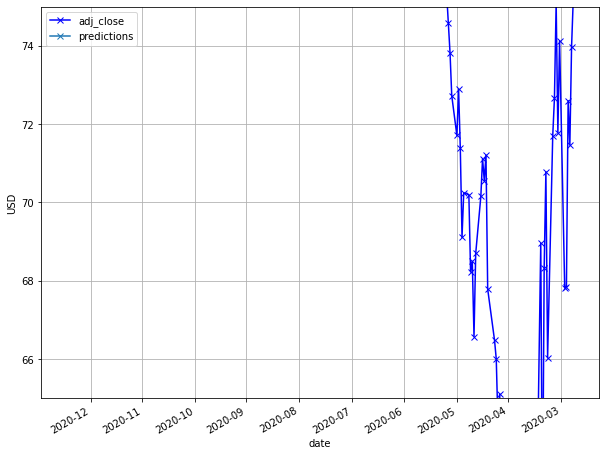

In [ ]:
# Plot the predictions
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='Date', y='Adj Close', style='bx-', grid=True)

# Plot the predictions
ax.plot(df['Date'][i:len(future)], preds_list, marker='x')
    
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.legend(['adj_close', 'predictions'])
ax.set_ylim([65, 75])
ax.set_xlim([date(2020, 12, 30), date(2020, 2, 8)])

In [ ]:
#importing libraries
#import matplotlib.pyplot as plt
#import matplotlib.animation as animation
#Set the figure for the animation framework
#fig = plt.figure(figsize = (10,6))
#creating a subplot 
#ax1 = fig.add_subplot(1,1,1)
#Preparing empty list as we want to animate the graph one data at a time rather than all at once
#date = []
#adjclose = []
#Using FuncAnimation we need to create an animation function which return and/or done a repetitive action
#def animate(i):
    #Append the empty list with the data located at the index i
    #date.append(df['Date'].loc[i])
    #adjclose.append(df['Adj Close'].loc[i])
    #Clear the subplot each time the animate is called
    #ax1.clear()
    
   # ax1.plot(date, adjclose)
    #ax1.tick_params(axis = 'x', labelrotation = 90)
    
    #ax1.set_xlabel('Date')
    #ax1.set_ylabel('Price')
    #ax1.set_title('Appl Stock graph with matplotlib')
    #return ax1

#ani = animation.FuncAnimation(fig = fig, func = animate, frames = len(df), interval = 20) 
#plt.show()
#You could decide wheteher it is gif or mp4 by change the extension name
#ani.save('deneme.gif', writer='imagemagick', fps=60)

#from matplotlib import rc
#rc('animation', html='html5')
#ani

## Holidays



In [ ]:
# Tatil dosyasını yükleme
hols = pd.read_csv(holidays_path, header=None, sep="\t", names=['ds', 'holiday'])

# Tarih kolonunu str'den DateTime çevirme
hols.loc[:, 'ds'] = pd.to_datetime(hols['ds'],format='%Y-%m-%d')

# Tatil dönemini tarihin +/- günleri [lower_window, upper_window] günlerine uzatan lower_window ve Upper_window eklenmesi
hols['lower_window'] = 0
hols['upper_window'] = 0

hols.head()
hols.tail(50)

,ds,holiday,lower_window,upper_window
10,2016-01-01,New Year's Day,0,0
11,2016-01-18,"Birthday of Martin Luther King, Jr.",0,0
12,2016-02-15,Washington's Birthday,0,0
13,2016-05-30,Memorial Day,0,0
14,2016-07-04,Independence Day,0,0
15,2016-09-05,Labor Day,0,0
16,2016-10-10,Columbus Day,0,0
17,2016-11-11,Veterans Day,0,0
18,2016-11-24,Thanksgiving Day,0,0
19,2016-12-26,Christmas Day,0,0


In [ ]:
def changepoint_prior_scale_hols(changepoint_prior_scale, hols):

  m = Prophet(changepoint_prior_scale=changepoint_prior_scale,holidays=hols)
  m.fit(df_prophet[i-train_size:i])
  future = m.make_future_dataframe(periods=H)
  future['day'] = future['ds'].dt.weekday
  future = future[future['day']<=4]
  forecast = m.predict(future)
  preds_list = forecast['yhat'][train_size:len(future)]
  rmse= get_rmse(df_prophet[i:len(future)]['y'], preds_list)
  mape= get_mape(df_prophet[i:len(future)]['y'], preds_list)
  mae= get_mae(df_prophet[i:len(future)]['y'], preds_list)
  r2 = get_r2(df_prophet[i:len(future)]['y'], preds_list)
  new_row2= {'changepoint_prior_scale':changepoint_prior_scale,'RMSE':rmse,'MAPE':mape,'MAE':mae, 'R^2': r2, 'Holidays':'True'}
  return new_row2

In [ ]:
Changepoint_prior_scale_value=round(errordf['changepoint_prior_scale'].iloc[0],2)
new_row=changepoint_prior_scale_hols(Changepoint_prior_scale_value, hols)
errordf = pd.DataFrame()
errordf=errordf.append(new_row, ignore_index=True)


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:

print(errordf)

  Holidays       MAE     MAPE      RMSE      R^2  changepoint_prior_scale
0     True  4.206759  5.45505  4.349978 -4.23654                      0.5


##Yearly Seasonality

In [ ]:
def yearly_seasonality(changepoint_prior_scale):
  m = Prophet(changepoint_prior_scale=changepoint_prior_scale, yearly_seasonality=True)
  m.fit(df_prophet[i-train_size:i])
  future = m.make_future_dataframe(periods=H)
  future['day'] = future['ds'].dt.weekday
  future = future[future['day']<=4]
  forecast = m.predict(future)
  preds_list = forecast['yhat'][train_size:len(future)]
  rmse= get_rmse(df_prophet[i:len(future)]['y'], preds_list)
  mape= get_mape(df_prophet[i:len(future)]['y'], preds_list)
  mae= get_mae(df_prophet[i:len(future)]['y'], preds_list)
  r2 = get_r2(df_prophet[i:len(future)]['y'], preds_list)
  new_row= {'changepoint_prior_scale':changepoint_prior_scale,'RMSE':rmse,'MAPE':mape,'MAE':mae, 'R^2':r2, 'Seasonality':'True'}
  return new_row

In [ ]:
Changepoint_prior_scale_value=round(errordf['changepoint_prior_scale'].iloc[0],2)
new_row=yearly_seasonality(Changepoint_prior_scale_value)
errordf = pd.DataFrame()
errordf=errordf.append(new_row, ignore_index=True)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
print(errordf)

        MAE      MAPE      RMSE       R^2 Seasonality  changepoint_prior_scale
0  1.108638  1.434342  1.323989  0.514891        True                      0.5


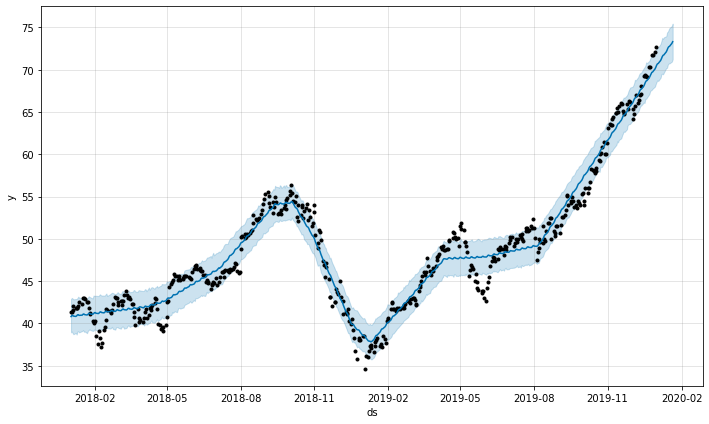

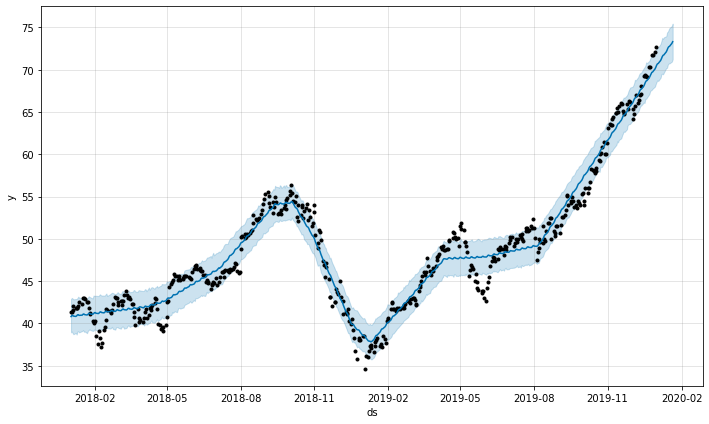

In [ ]:
m.plot(forecast)

(737423.0, 737452.0)

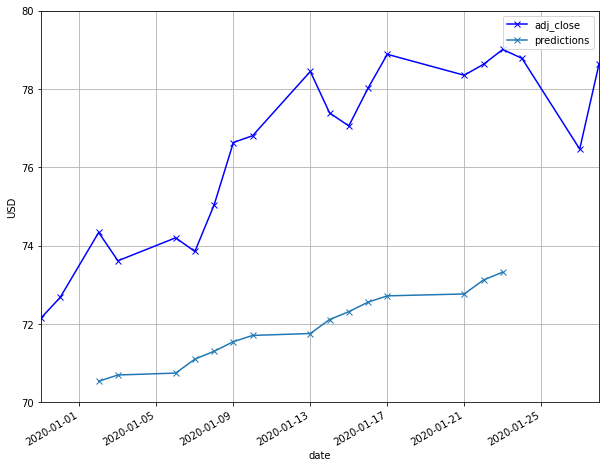

In [ ]:
# Plot the predictions
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='Date', y='Adj Close', style='bx-', grid=True)

# Plot the predictions
ax.plot(df['Date'][i:len(future)], preds_list, marker='x')
    
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.legend(['adj_close', 'predictions'])
ax.set_ylim([70, 80])
ax.set_xlim([date(2019, 12, 30), date(2020, 1, 28)])

##Holidays + Yearly Seasonality

In [ ]:
def hols_yearly_seasonality(changepoint_prior_scale, hols):
  m = Prophet(changepoint_prior_scale=changepoint_prior_scale, holidays=hols, yearly_seasonality=True)
  m.fit(df_prophet[i-train_size:i])
  future = m.make_future_dataframe(periods=H)
  future['day'] = future['ds'].dt.weekday
  future = future[future['day']<=4]
  forecast = m.predict(future)
  preds_list = forecast['yhat'][train_size:len(future)]
  rmse= get_rmse(df_prophet[i:len(future)]['y'], preds_list)
  mape= get_mape(df_prophet[i:len(future)]['y'], preds_list)
  mae= get_mae(df_prophet[i:len(future)]['y'], preds_list)
  r2 = get_r2(df_prophet[i:len(future)]['y'], preds_list)
  new_row= {'changepoint_prior_scale':changepoint_prior_scale,'RMSE':rmse,'MAPE':mape,'MAE':mae,'R^2':r2, 'Seasonality':'True'}
  return new_row

In [ ]:
Changepoint_prior_scale_value=round(errordf['changepoint_prior_scale'].iloc[0],2)
new_row=hols_yearly_seasonality(Changepoint_prior_scale_value, hols)
errordf = pd.DataFrame()
errordf=errordf.append(new_row, ignore_index=True)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
print(errordf)

       MAE      MAPE      RMSE       R^2 Seasonality  changepoint_prior_scale
0  0.98622  1.276171  1.164569  0.624681        True                      0.5


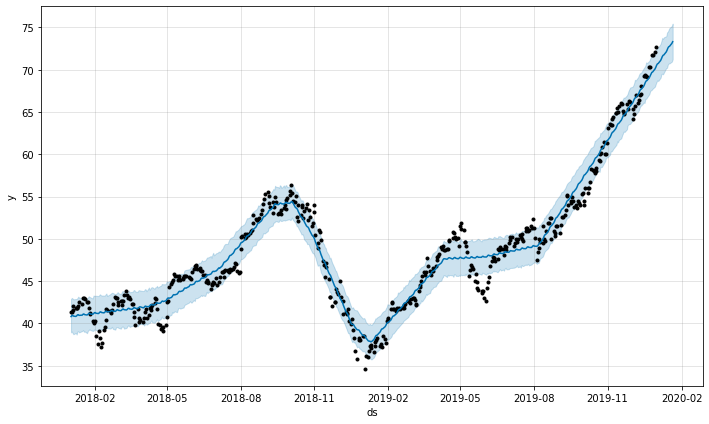

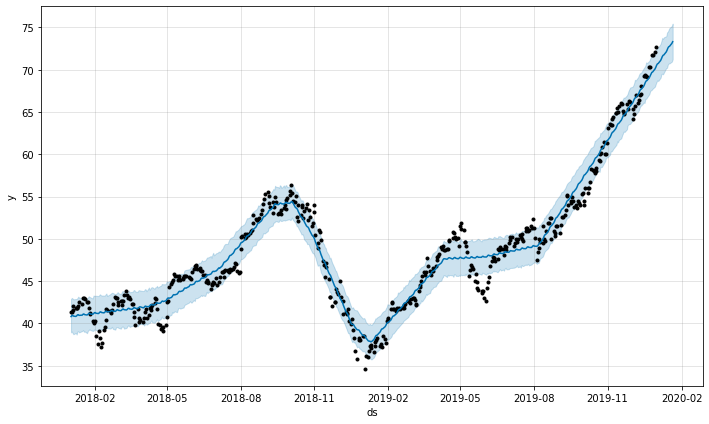

In [ ]:
m.plot(forecast)

(737423.0, 737452.0)

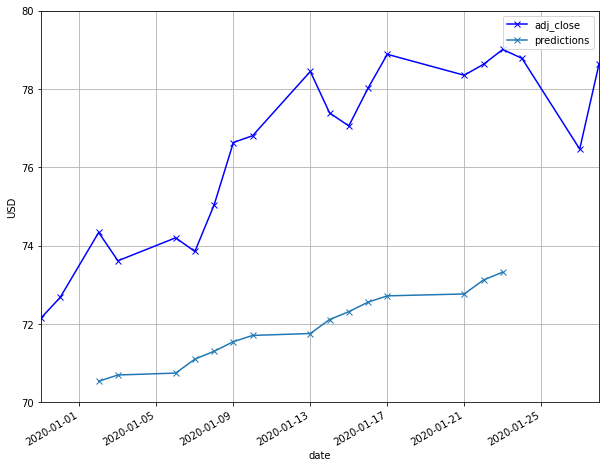

In [ ]:
# Plot the predictions
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='Date', y='Adj Close', style='bx-', grid=True)

# Plot the predictions
ax.plot(df['Date'][i:len(future)], preds_list, marker='x')
    
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.legend(['adj_close', 'predictions'])
ax.set_ylim([70, 80])
ax.set_xlim([date(2019, 12, 30), date(2020, 1, 28)])

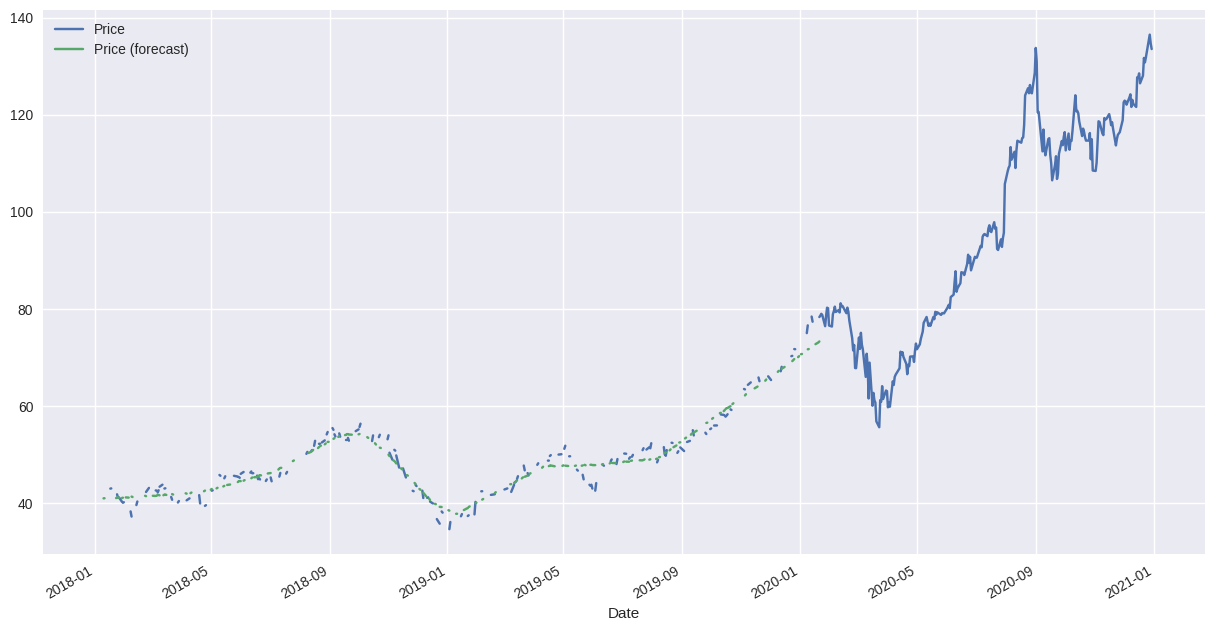

In [ ]:
PLOT_COLUMS = [
    "Price",
    "Price (forecast)",
]

plt.style.use("seaborn")

result_df = df_prophet.copy()

# Add first result from forecast as y to connect dots
result_df = result_df.append(result_df.tail(1).rename(columns = {"y": "yhat"}))

result_df = result_df.append(forecast)

result_df = result_df.rename(columns = {
    "ds": "Date",
    "y": "Price",
    "yhat": "Price (forecast)"
})

fig = plt.figure(dpi=100)

fig.set_facecolor("white")

plot = result_df.plot(x="Date", y=PLOT_COLUMS, figsize=(15, 8), ax=fig.gca())

plot_fig = plot.get_figure()

plot_fig.savefig('forecast.png')

##Monthly Seasonality

In [ ]:
def monthly_seasonality(changepoint_prior_scale):
  m = Prophet(changepoint_prior_scale=changepoint_prior_scale, yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False)
  m.add_seasonality(name='monthly', period=21, fourier_order=5)
  m.fit(df_prophet[i-train_size:i])
  future = m.make_future_dataframe(periods=H)
  future['day'] = future['ds'].dt.weekday
  future = future[future['day']<=4]
  forecast = m.predict(future)
  preds_list = forecast['yhat'][train_size:len(future)]
  rmse= get_rmse(df_prophet[i:len(future)]['y'], preds_list)
  mape= get_mape(df_prophet[i:len(future)]['y'], preds_list)
  mae= get_mae(df_prophet[i:len(future)]['y'], preds_list)
  r2 = get_r2(df_prophet[i:len(future)]['y'], preds_list)
  new_row= {'changepoint_prior_scale':changepoint_prior_scale,'RMSE':rmse,'MAPE':mape,'MAE':mae, 'R^2':r2, 'Seasonality':'True'}
  return new_row

In [ ]:
Changepoint_prior_scale_value=round(errordf['changepoint_prior_scale'].iloc[0],2)
new_row=monthly_seasonality(Changepoint_prior_scale_value)
errordf = pd.DataFrame()
errordf=errordf.append(new_row, ignore_index=True)

In [ ]:
print(errordf)

        MAE      MAPE      RMSE       R^2 Seasonality  changepoint_prior_scale
0  4.177228  5.414267  4.335587 -4.201949        True                      0.5


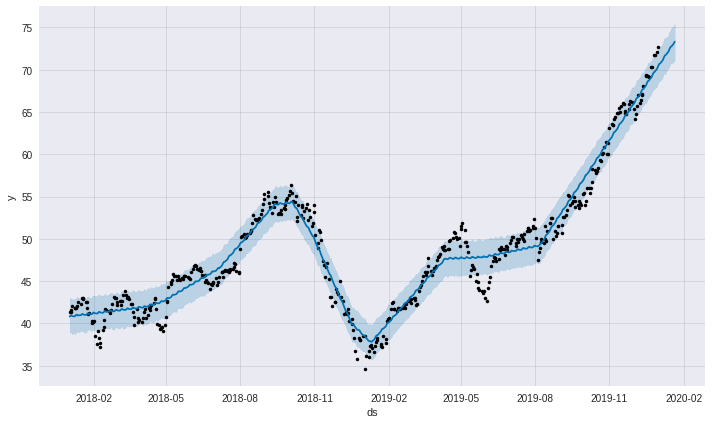

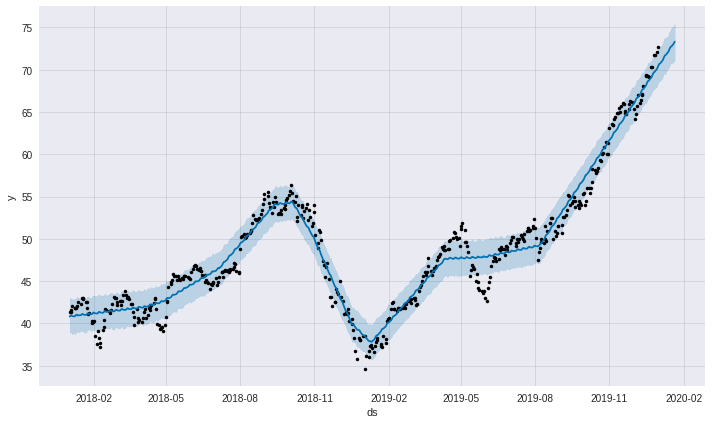

In [ ]:
m.plot(forecast)

(737423.0, 737452.0)

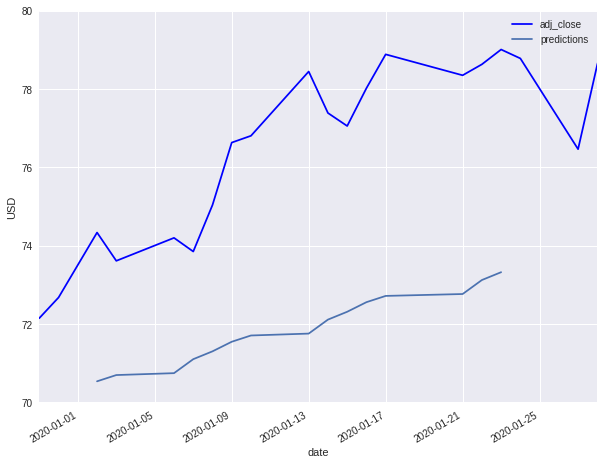

In [ ]:

rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='Date', y='Adj Close', style='bx-', grid=True)


ax.plot(df['Date'][i:len(future)], preds_list, marker='x')
    
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.legend(['adj_close', 'predictions'])
ax.set_ylim([70, 80])
ax.set_xlim([date(2019, 12, 30), date(2020, 1, 28)])

##Holidays + Monthly Seasonality

In [ ]:
def hols_monthly_seasonality(changepoint_prior_scale, hols):
  m = Prophet(changepoint_prior_scale=changepoint_prior_scale, holidays=hols, weekly_seasonality=False,yearly_seasonality=False, daily_seasonality=False)
  m.add_seasonality(name='monthly', period=21, fourier_order=5)
  m.fit(df_prophet[i-train_size:i])
  future = m.make_future_dataframe(periods=H)
  future['day'] = future['ds'].dt.weekday
  future = future[future['day']<=4]
  forecast = m.predict(future)
  preds_list = forecast['yhat'][train_size:len(future)]
  rmse= get_rmse(df_prophet[i:len(future)]['y'], preds_list)
  mape= get_mape(df_prophet[i:len(future)]['y'], preds_list)
  mae= get_mae(df_prophet[i:len(future)]['y'], preds_list)
  r2 = get_r2(df_prophet[i:len(future)]['y'], preds_list)
  new_row= {'changepoint_prior_scale':changepoint_prior_scale,'RMSE':rmse,'MAPE':mape,'MAE':mae,'R^2':r2, 'Seasonality':'True'}
  return new_row

In [ ]:
Changepoint_prior_scale_value=round(errordf['changepoint_prior_scale'].iloc[0],2)
new_row=hols_monthly_seasonality(Changepoint_prior_scale_value, hols)
errordf = pd.DataFrame()
errordf=errordf.append(new_row, ignore_index=True)

In [ ]:
print(errordf)

        MAE      MAPE      RMSE       R^2 Seasonality  changepoint_prior_scale
0  4.182288  5.420886  4.340273 -4.213199        True                      0.5


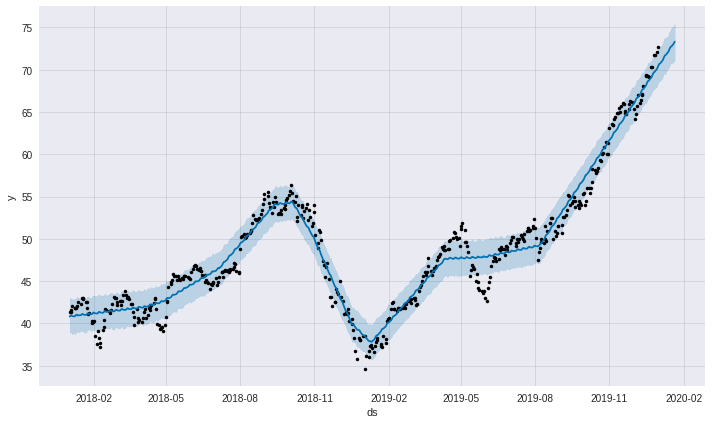

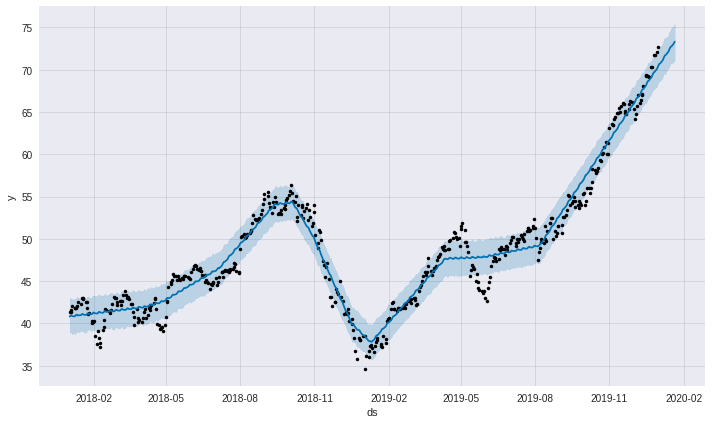

In [ ]:
m.plot(forecast)

(737423.0, 737452.0)

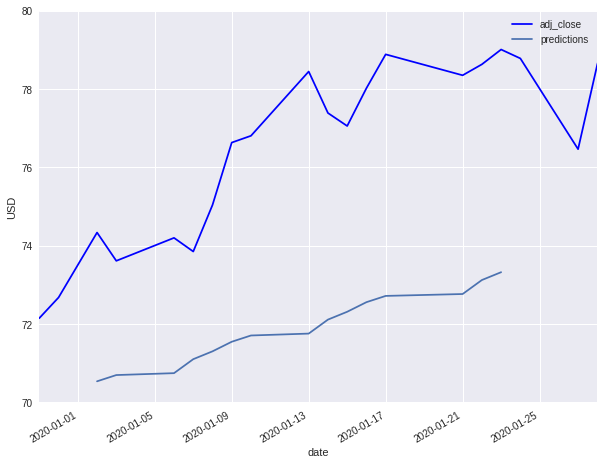

In [ ]:
# Plot the predictions
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='Date', y='Adj Close', style='bx-', grid=True)

# Plot the predictions
ax.plot(df['Date'][i:len(future)], preds_list, marker='x')
    
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.legend(['adj_close', 'predictions'])
ax.set_ylim([70, 80])
ax.set_xlim([date(2019, 12, 30), date(2020, 1, 28)])

## Weekly Seasonality

In [ ]:
def weekly_seasonality(changepoint_prior_scale):
  m = Prophet(changepoint_prior_scale=changepoint_prior_scale, weekly_seasonality=True)
  m.fit(df_prophet[i-train_size:i])
  future = m.make_future_dataframe(periods=H)
  future['day'] = future['ds'].dt.weekday
  future = future[future['day']<=4]
  forecast = m.predict(future)
  preds_list = forecast['yhat'][train_size:len(future)]
  rmse= get_rmse(df_prophet[i:len(future)]['y'], preds_list)
  mape= get_mape(df_prophet[i:len(future)]['y'], preds_list)
  mae= get_mae(df_prophet[i:len(future)]['y'], preds_list)
  r2 = get_r2(df_prophet[i:len(future)]['y'], preds_list)
  new_row= {'changepoint_prior_scale':changepoint_prior_scale,'RMSE':rmse,'MAPE':mape,'MAE':mae, 'R^2':r2, 'Seasonality':'True'}
  return new_row

In [ ]:
Changepoint_prior_scale_value=round(errordf['changepoint_prior_scale'].iloc[0],2)
new_row=weekly_seasonality(Changepoint_prior_scale_value)
errordf = pd.DataFrame()
errordf=errordf.append(new_row, ignore_index=True)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
print(errordf)

        MAE     MAPE      RMSE       R^2 Seasonality  changepoint_prior_scale
0  4.197261  5.44266  4.340907 -4.214724        True                      0.5


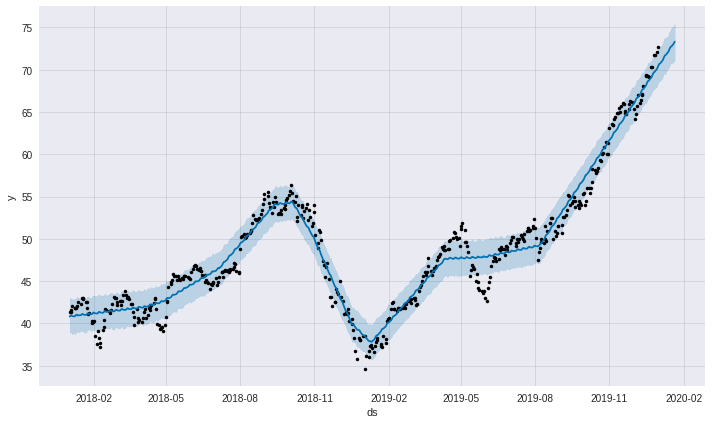

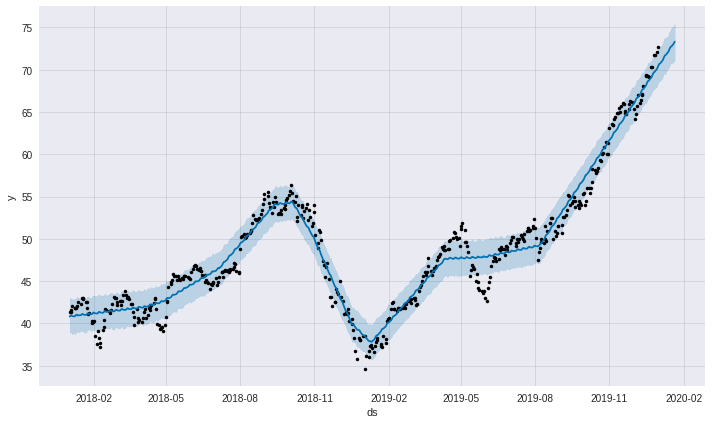

In [ ]:
m.plot(forecast)

(737423.0, 737452.0)

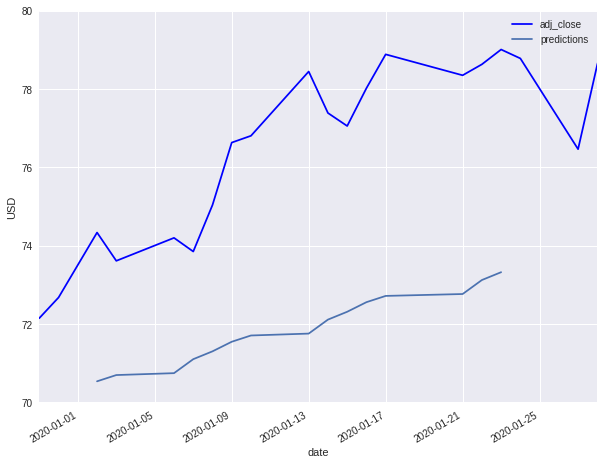

In [ ]:

rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='Date', y='Adj Close', style='bx-', grid=True)


ax.plot(df['Date'][i:len(future)], preds_list, marker='x')
    
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.legend(['adj_close', 'predictions'])
ax.set_ylim([70, 80])
ax.set_xlim([date(2019, 12, 30), date(2020, 1, 28)])

## Holidays + Weekly Seasonality

In [ ]:
def hols_weekly_seasonality(changepoint_prior_scale, hols):
  m = Prophet(changepoint_prior_scale=changepoint_prior_scale, holidays=hols, weekly_seasonality=True,yearly_seasonality=False, daily_seasonality=False)
  m.fit(df_prophet[i-train_size:i])
  future = m.make_future_dataframe(periods=H)
  future['day'] = future['ds'].dt.weekday
  future = future[future['day']<=4]
  forecast = m.predict(future)
  preds_list = forecast['yhat'][train_size:len(future)]
  rmse= get_rmse(df_prophet[i:len(future)]['y'], preds_list)
  mape= get_mape(df_prophet[i:len(future)]['y'], preds_list)
  mae= get_mae(df_prophet[i:len(future)]['y'], preds_list)
  r2 = get_r2(df_prophet[i:len(future)]['y'], preds_list)
  new_row= {'changepoint_prior_scale':changepoint_prior_scale,'RMSE':rmse,'MAPE':mape,'MAE':mae,'R^2':r2, 'Seasonality':'True'}
  return new_row

In [ ]:
Changepoint_prior_scale_value=round(errordf['changepoint_prior_scale'].iloc[0],2)
new_row=hols_weekly_seasonality(Changepoint_prior_scale_value, hols)
errordf = pd.DataFrame()
errordf=errordf.append(new_row, ignore_index=True)

In [ ]:
print(errordf)

        MAE     MAPE      RMSE      R^2 Seasonality  changepoint_prior_scale
0  4.206759  5.45505  4.349978 -4.23654        True                      0.5


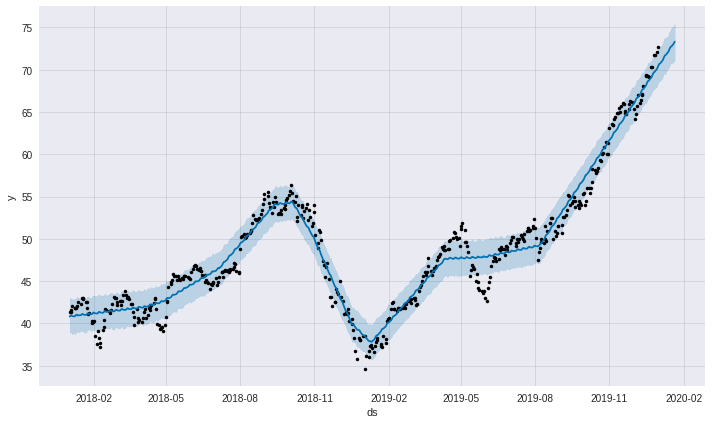

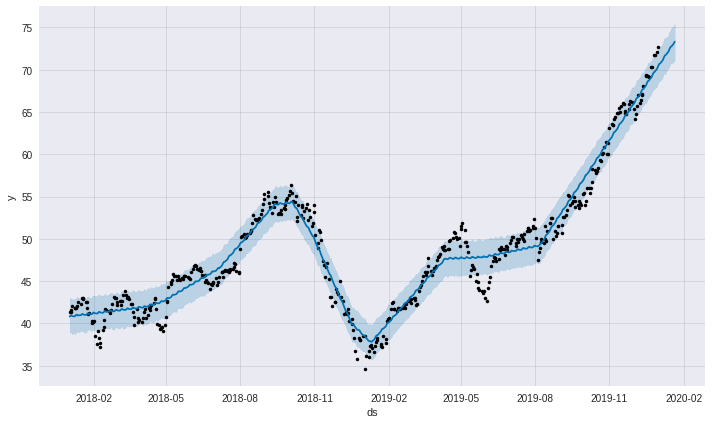

In [ ]:
m.plot(forecast)

(737423.0, 737452.0)

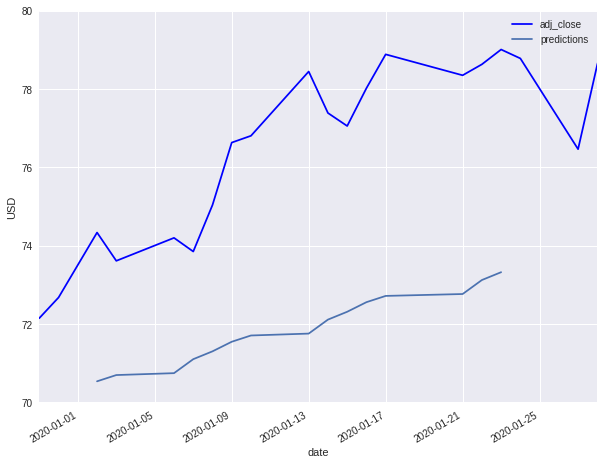

In [ ]:
# Plot the predictions
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='Date', y='Adj Close', style='bx-', grid=True)

# Plot the predictions
ax.plot(df['Date'][i:len(future)], preds_list, marker='x')
    
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.legend(['adj_close', 'predictions'])
ax.set_ylim([70, 80])
ax.set_xlim([date(2019, 12, 30), date(2020, 1, 28)])

## Daily Seasonality

In [ ]:
def daily_seasonality(changepoint_prior_scale):
  m = Prophet(changepoint_prior_scale=changepoint_prior_scale, daily_seasonality=True)
  m.fit(df_prophet[i-train_size:i])
  future = m.make_future_dataframe(periods=H)
  future['day'] = future['ds'].dt.weekday
  future = future[future['day']<=4]
  forecast = m.predict(future)
  preds_list = forecast['yhat'][train_size:len(future)]
  rmse= get_rmse(df_prophet[i:len(future)]['y'], preds_list)
  mape= get_mape(df_prophet[i:len(future)]['y'], preds_list)
  mae= get_mae(df_prophet[i:len(future)]['y'], preds_list)
  r2 = get_r2(df_prophet[i:len(future)]['y'], preds_list)
  new_row= {'changepoint_prior_scale':changepoint_prior_scale,'RMSE':rmse,'MAPE':mape,'MAE':mae, 'R^2':r2, 'Seasonality':'True'}
  return new_row

In [ ]:
Changepoint_prior_scale_value=round(errordf['changepoint_prior_scale'].iloc[0],2)
new_row=daily_seasonality(Changepoint_prior_scale_value)
errordf = pd.DataFrame()
errordf=errordf.append(new_row, ignore_index=True)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [ ]:
print(errordf)

        MAE      MAPE     RMSE       R^2 Seasonality  changepoint_prior_scale
0  4.191666  5.435374  4.33541 -4.201523        True                      0.5


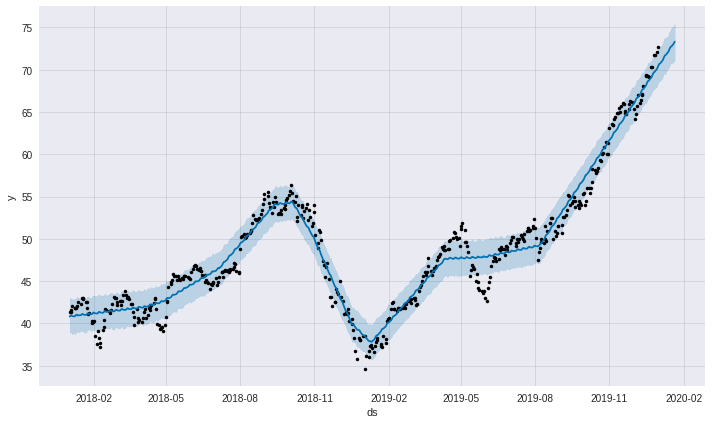

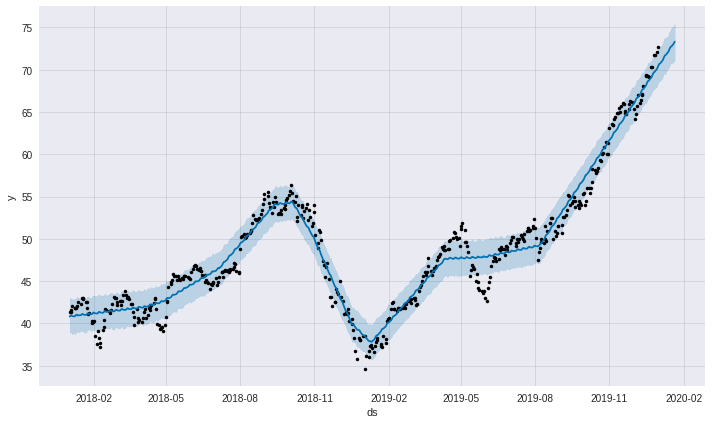

In [ ]:
m.plot(forecast)

(737423.0, 737452.0)

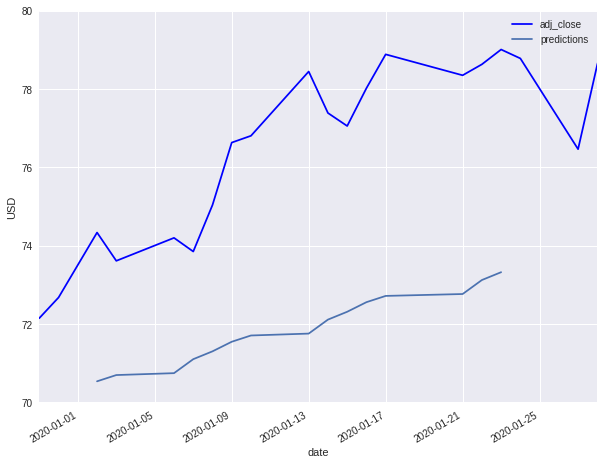

In [ ]:

rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='Date', y='Adj Close', style='bx-', grid=True)


ax.plot(df['Date'][i:len(future)], preds_list, marker='x')
    
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.legend(['adj_close', 'predictions'])
ax.set_ylim([70, 80])
ax.set_xlim([date(2019, 12, 30), date(2020, 1, 28)])

##Holidays + Daily Seasonality

In [ ]:
def hols_daily_seasonality(changepoint_prior_scale, hols):
  m = Prophet(changepoint_prior_scale=changepoint_prior_scale, holidays=hols, daily_seasonality=True)
  m.fit(df_prophet[i-train_size:i])
  future = m.make_future_dataframe(periods=H)
  future['day'] = future['ds'].dt.weekday
  future = future[future['day']<=4]
  forecast = m.predict(future)
  preds_list = forecast['yhat'][train_size:len(future)]
  rmse= get_rmse(df_prophet[i:len(future)]['y'], preds_list)
  mape= get_mape(df_prophet[i:len(future)]['y'], preds_list)
  mae= get_mae(df_prophet[i:len(future)]['y'], preds_list)
  r2 = get_r2(df_prophet[i:len(future)]['y'], preds_list)
  new_row= {'changepoint_prior_scale':changepoint_prior_scale,'RMSE':rmse,'MAPE':mape,'MAE':mae,'R^2':r2, 'Seasonality':'True'}
  return new_row

In [ ]:
Changepoint_prior_scale_value=round(errordf['changepoint_prior_scale'].iloc[0],2)
new_row=hols_daily_seasonality(Changepoint_prior_scale_value, hols)
errordf = pd.DataFrame()
errordf=errordf.append(new_row, ignore_index=True)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [ ]:
print(errordf)

        MAE     MAPE      RMSE      R^2 Seasonality  changepoint_prior_scale
0  4.215665  5.46665  4.358729 -4.25763        True                      0.5


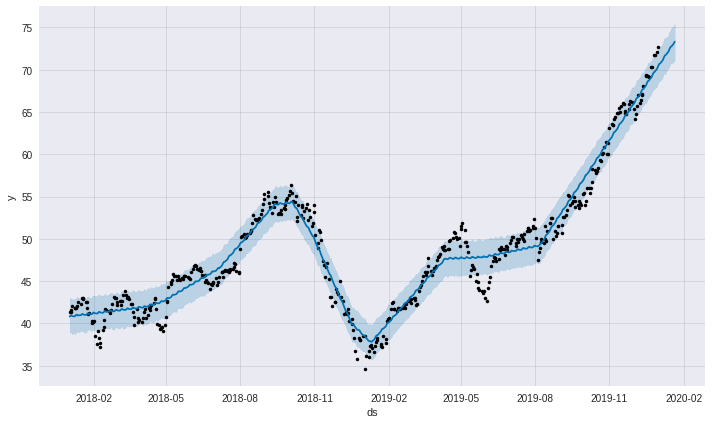

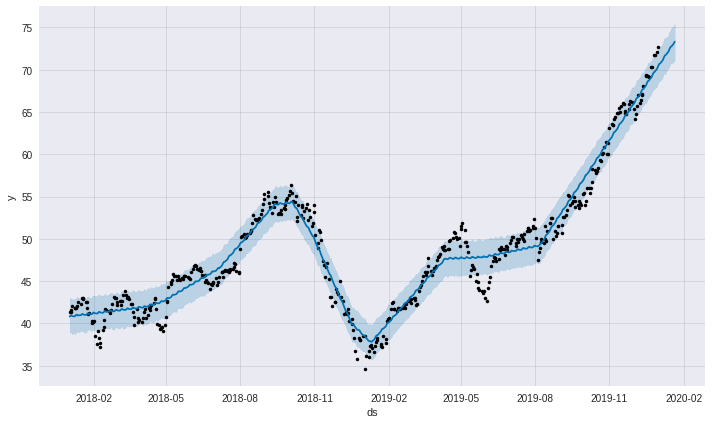

In [ ]:
m.plot(forecast)

(737423.0, 737452.0)

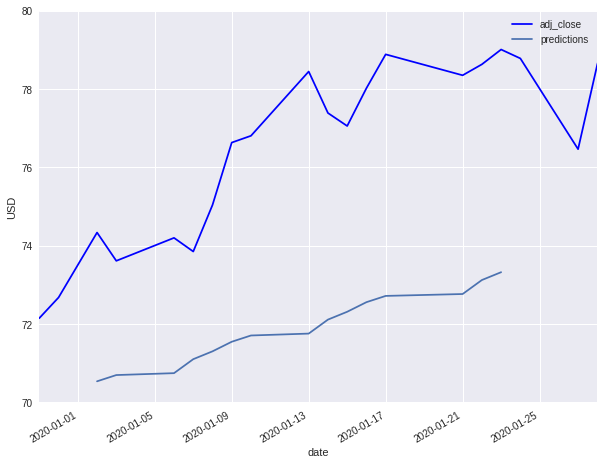

In [ ]:

rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='Date', y='Adj Close', style='bx-', grid=True)


ax.plot(df['Date'][i:len(future)], preds_list, marker='x')
    
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.legend(['adj_close', 'predictions'])
ax.set_ylim([70, 80])
ax.set_xlim([date(2019, 12, 30), date(2020, 1, 28)])

## Hiper parametre Optimizasyonu

In [ ]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'holidays_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Parametrelerin Tüm kombinasyonları oluşturduğumuz satır
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Her parametrenin RMSE değerini sakladığımız dizi
mses = [] 
maes = [] 
mapes = [] 
r2 =[] #Her parametrenin R^2 değerini sakladığımız dizi

#Tüm parametreleri değerlendirmek için çapraz doğrulamayı kullandığımız döngü
for params in all_params:
    m = Prophet(**params).fit(df_prophet)  # Fit model with given params
    df_cv = cross_validation(m, initial='503 days',horizon='15 days', period='5 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    df_r = get_r2(df_cv['y'],df_cv['yhat'])
    rmses.append(df_p['rmse'].values[0])
    mses.append(df_p['mse'].values[0])
    maes.append(df_p['mae'].values[0])
    mapes.append(df_p['mape'].values[0])
    r2.append(df_r)
print(df_cv)
print(df_r)
# Parametre sonuçları
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
tuning_results['mse'] = mses
tuning_results['mae'] = maes
tuning_results['mae'] = mapes
tuning_results['r2'] = r2
print(tuning_results)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 116 forecasts with cutoffs between 2019-05-21 00:00:00 and 2020-12-16 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff4ff25eed0>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 116 forecasts with cutoffs between 2019-05-21 00:00:00 and 2020-12-16 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff4ff347750>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 116 forecasts with cutoffs between 2019-05-21 00:00:00 and 2020-12-16 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff4f67b4210>
INFO:fbprophet:Disabling daily seasonality. Ru

             ds        yhat  yhat_lower  yhat_upper           y     cutoff
0    2019-05-22   44.598906   43.549815   45.641677   44.930046 2019-05-21
1    2019-05-23   44.228879   43.208002   45.264453   44.163101 2019-05-21
2    2019-05-24   43.743043   42.636543   44.865055   43.993488 2019-05-21
3    2019-05-28   42.185839   41.031936   43.349817   43.811584 2019-05-21
4    2019-05-29   41.961698   40.781794   43.080332   43.602642 2019-05-21
...         ...         ...         ...         ...         ...        ...
1198 2020-12-24  127.354488  124.276559  130.303340  131.773087 2020-12-16
1199 2020-12-28  128.538861  125.472492  131.699213  136.486053 2020-12-16
1200 2020-12-29  129.004427  125.869290  131.861615  134.668762 2020-12-16
1201 2020-12-30  129.522429  126.453084  132.656835  133.520477 2020-12-16
1202 2020-12-31  129.812780  126.521158  133.005146  132.492020 2020-12-16

[1203 rows x 6 columns]
0.9472004752683099
    changepoint_prior_scale  seasonality_prior_scale  ..

In [ ]:
print(df_cv)
df_cv.to_csv('df_cv.csv')
df_p.to_csv('df_p.csv')
#df_r.to_csv('df_r.csv')
tuning_results.to_csv('tuning_results.csv')


             ds        yhat  yhat_lower  yhat_upper           y     cutoff
0    2019-05-22   44.598906   43.549815   45.641677   44.930046 2019-05-21
1    2019-05-23   44.228879   43.208002   45.264453   44.163101 2019-05-21
2    2019-05-24   43.743043   42.636543   44.865055   43.993488 2019-05-21
3    2019-05-28   42.185839   41.031936   43.349817   43.811584 2019-05-21
4    2019-05-29   41.961698   40.781794   43.080332   43.602642 2019-05-21
...         ...         ...         ...         ...         ...        ...
1198 2020-12-24  127.354488  124.276559  130.303340  131.773087 2020-12-16
1199 2020-12-28  128.538861  125.472492  131.699213  136.486053 2020-12-16
1200 2020-12-29  129.004427  125.869290  131.861615  134.668762 2020-12-16
1201 2020-12-30  129.522429  126.453084  132.656835  133.520477 2020-12-16
1202 2020-12-31  129.812780  126.521158  133.005146  132.492020 2020-12-16

[1203 rows x 6 columns]


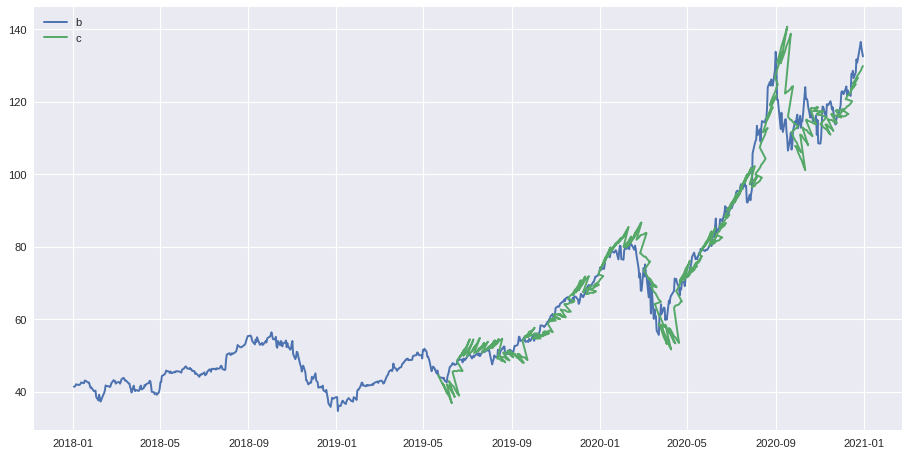

In [ ]:

plt.figure(figsize=[14,7],dpi=80)
plt.plot(df['Date'],df['Adj Close'])
plt.plot(df_cv['ds'],df_cv['yhat'])
plt.legend(['b','c'])
plt.savefig(fname="Tahminleme.png")


# Conclusion // Sonuç

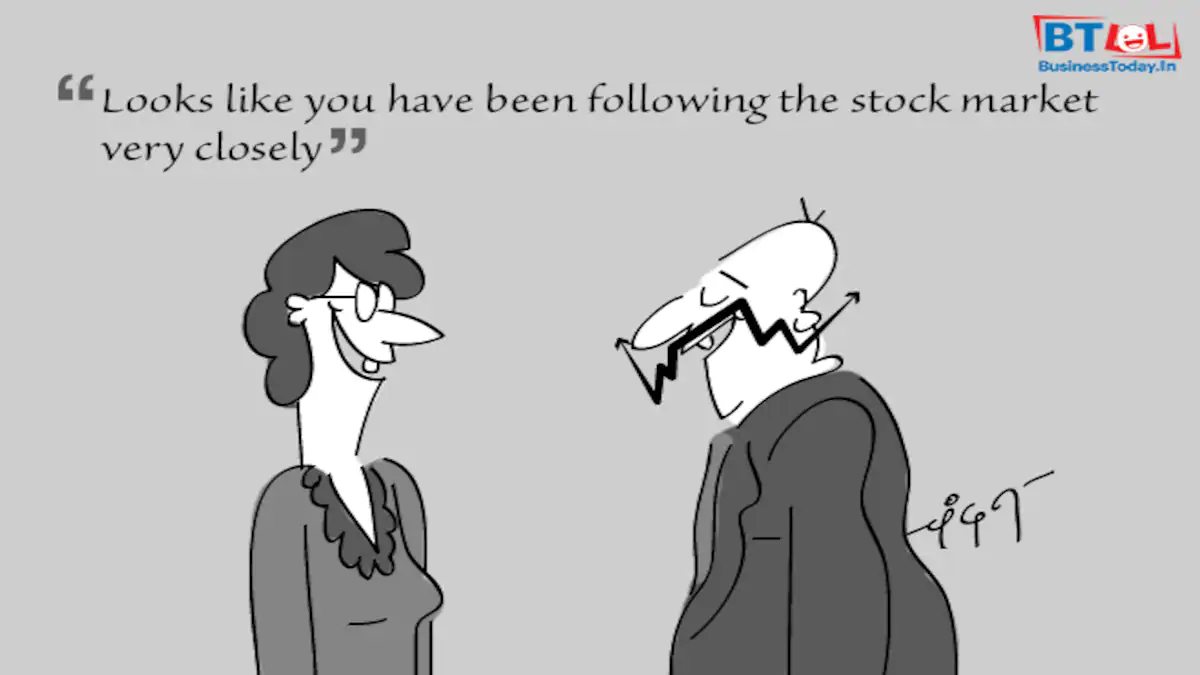